In [1]:
# dependencies
% load_ext autoreload
% autoreload 2
import sys
sys.path.append('../../..')
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

# prysm
from prysm import FringeZernike, Seidel, SurfaceFinish, PSF, MTF, Detector, OLPF, PixelAperture, SiemensStar
from prysm.conf import config
config.set_precision(32)

# zoom zoom
from multiprocessing.dummy import Pool as ThreadPool
from functools import partial

# style
%matplotlib inline
inline_rc = dict(mpl.rcParams)
plt_args = dict(dpi=150, bbox_inches='tight')

C:\Users\brand\Anaconda3\lib\site-packages\numba\decorators.py:149: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [2]:
# example 
pixsize = 6
olpf_size = 0.375
example_pupil = FringeZernike(epd=50/1.4)
psf = PSF.from_pupil(example_pupil, efl=50)
pix = PixelAperture(pixsize)
olpf = OLPF(olpf_size*pixsize)

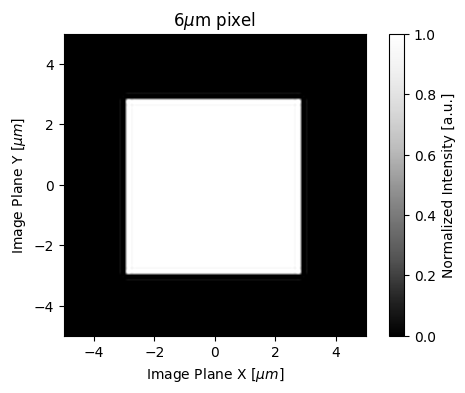

In [3]:
# plot of ex pixel
pix.plot2d(axlim=5)
plt.gca().set(title=f'{pixsize}$\mu$m pixel')
plt.savefig('Video_outputs/pixel.png', **plt_args)

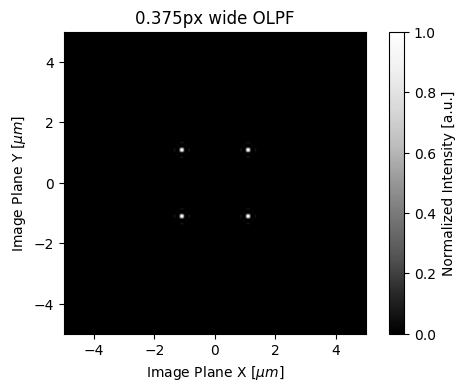

In [4]:
#plot of ex OLPF
olpf.plot2d(axlim=5)
plt.gca().set(title=f'{olpf_size}px wide OLPF')
plt.savefig('Video_outputs/olpf.png', **plt_args)

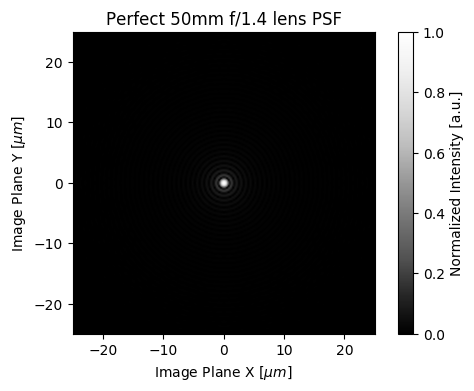

In [5]:
# plot of the lens PSF
lens_psf = PSF.from_pupil(example_pupil, efl=50)
lens_olpf_psf = lens_psf.conv(olpf)

lens_psf.plot2d()
plt.gca().set(title='Perfect 50mm f/1.4 lens PSF')
plt.savefig('Video_outputs/examplelens_psf.png', **plt_args)

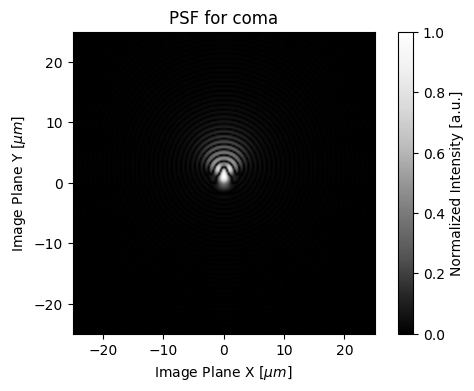

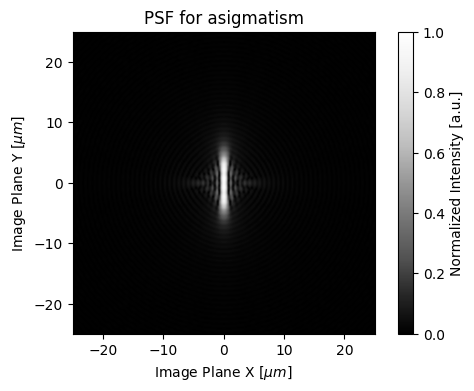

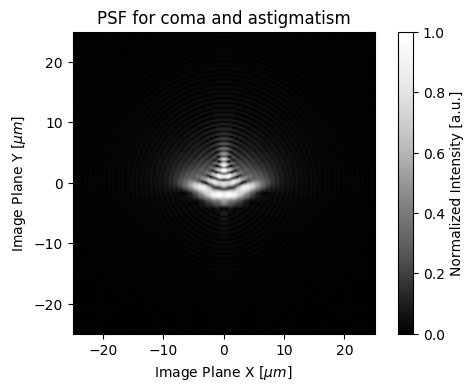

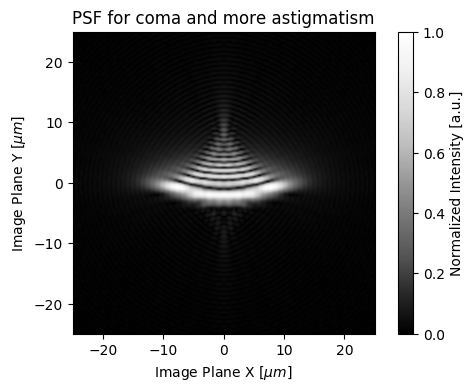

In [6]:
# interject with images of coma, astigmatism, and combinations
coma_pupil = Seidel(W131=1, epd=50/1.4)
coma_psf = PSF.from_pupil(coma_pupil, 50)
coma_psf.plot2d()
plt.gca().set(title='PSF for coma')
plt.savefig('Video_outputs/example_coma_psf.png', **plt_args)

astig_pupil = Seidel(W222=1, epd=50/1.4)
astig_psf = PSF.from_pupil(astig_pupil, 50)
astig_psf.plot2d()
plt.gca().set(title='PSF for asigmatism')
plt.savefig('Video_outputs/example_astig_psf.png', **plt_args)

coma_astig_pupil = Seidel(W111=-1, W020=-1, W222=1, W131=1, epd=50/1.4)
coma_astig_psf = PSF.from_pupil(coma_astig_pupil, 50)
coma_astig_psf.plot2d()
plt.gca().set(title='PSF for coma and astigmatism')
plt.savefig('Video_outputs/example_coma_and_astig_psf.png', **plt_args)

coma_astig_pupil = Seidel(W111=-1, W020=-2, W222=2, W131=1, epd=50/1.4)
coma_astig_psf = PSF.from_pupil(coma_astig_pupil, 50)
coma_astig_psf.plot2d()
plt.gca().set(title='PSF for coma and more astigmatism')
plt.savefig('Video_outputs/example_coma_and_more_astig_psf.png', **plt_args)

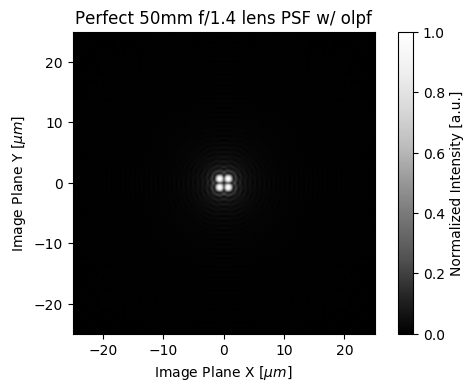

In [7]:
# plot of lens and OLPF combined
lens_olpf_psf.plot2d()
plt.gca().set(title='Perfect 50mm f/1.4 lens PSF w/ olpf')
plt.savefig('Video_outputs/examplelens+olpf_psf.png', **plt_args)

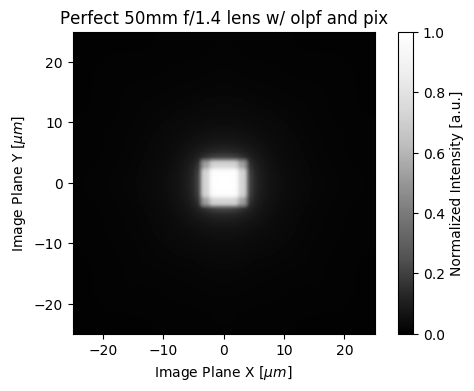

In [8]:
# plot of lens+olpf+pixel
lens_olpf_pix_psf = lens_olpf_psf.conv(pix)
lens_olpf_pix_psf.plot2d()
plt.gca().set(title='Perfect 50mm f/1.4 lens w/ olpf and pix')
plt.savefig('Video_outputs/exlens+olpf+pixpsf.png', **plt_args)

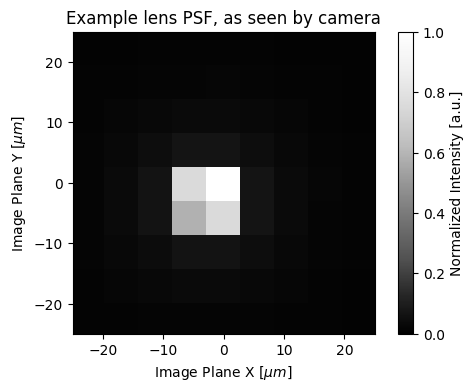

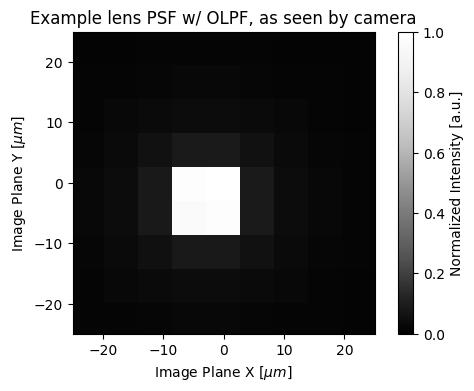

In [9]:
# show what your camera would see for these PSFs
det = Detector(pixsize)
pic = det.sample_psf(lens_psf).as_psf()
pic2 = det.sample_psf(lens_olpf_psf).as_psf()

# bump up the exposure
pic._renorm()
pic2._renorm()

# plot and save
pic.plot2d(interp_method='None')
plt.gca().set(title='Example lens PSF, as seen by camera')
plt.savefig('Video_outputs/example_lens_sample.png', **plt_args)
pic2.plot2d(interp_method='None')
plt.gca().set(title='Example lens PSF w/ OLPF, as seen by camera')
plt.savefig('Video_outputs/example_lens_olpf_sample.png', **plt_args)

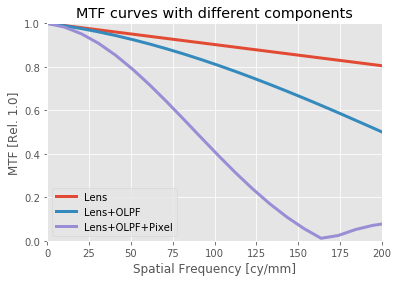

In [10]:
# MTF of different pieces of the system combined
mlens = MTF.from_psf(lens_psf)
mlolpf = MTF.from_psf(lens_olpf_psf)
mlopix = MTF.from_psf(lens_olpf_pix_psf)

ul, tl = mlens.tan
uol, tol = mlolpf.tan
ulop, tlop = mlopix.tan

plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.plot(ul,tl, label='Lens', lw=3)
ax.plot(uol, tol, label='Lens+OLPF', lw=3)
ax.plot(ulop, tlop, label='Lens+OLPF+Pixel', lw=3)
plt.legend()
ax.set(xlim=(0,200), xlabel='Spatial Frequency [cy/mm]',
       ylim=(0,1), ylabel='MTF [Rel. 1.0]',
       title='MTF curves with different components');
plt.savefig('Video_outputs/sys_mtf_components.png', **plt_args)

In [11]:
# create the three lenses we're going to use in our simulations
efl = 50
fno = 2.8
lens_names = ['Excellent', 'Good', 'Okay']
psf_args = dict(efl=efl, padding=4)
opd_setup = dict(opd_unit='nm', rms_norm=True, samples=256)

fabrication_errors = SurfaceFinish(amplitude=25, epd=efl/fno, opd_unit='nm', samples=256)
excellent_pupil = FringeZernike(Z8=20, Z15=-10, epd=efl/fno, **opd_setup)
good_pupil = FringeZernike(Z8=35, Z15=-20, epd=efl/fno, **opd_setup)
okay_pupil = FringeZernike(Z8=65, Z15=-15, epd=efl/fno, **opd_setup)

psf_excellent = PSF.from_pupil(excellent_pupil.merge(fabrication_errors), **psf_args)
psf_good = PSF.from_pupil(good_pupil.merge(fabrication_errors), **psf_args)
psf_okay = PSF.from_pupil(okay_pupil.merge(fabrication_errors), **psf_args)

mtf_excellent = MTF.from_psf(psf_excellent)
mtf_good = MTF.from_psf(psf_good)
mtf_okay = MTF.from_psf(psf_okay)

lens_psfs = [psf_excellent, psf_good, psf_okay]

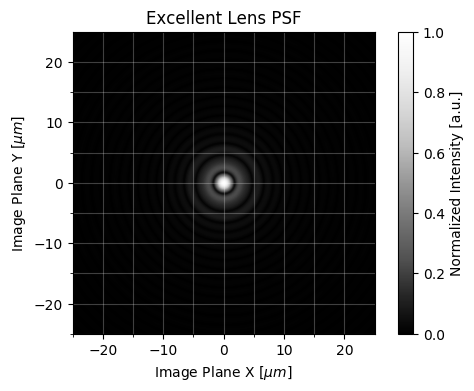

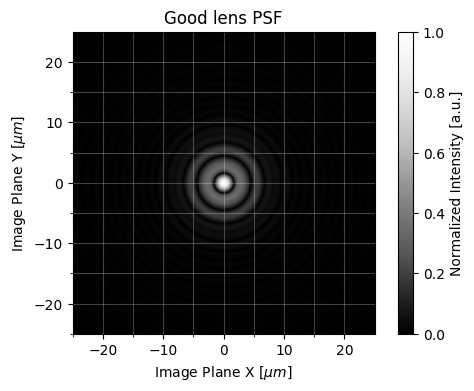

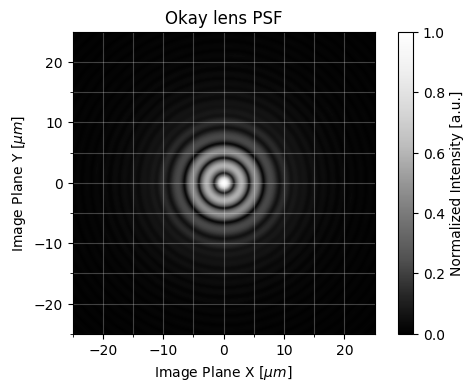

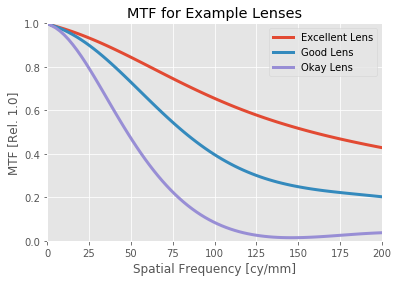

In [12]:
# plot their interferograms, PSFs, and MTFs
mpl.rcParams.update(inline_rc)

psf_excellent.plot2d(pix_grid=5)
plt.gca().set(title='Excellent Lens PSF')
plt.savefig('Video_outputs/exlens_psf.png', **plt_args)

psf_good.plot2d(pix_grid=5)
plt.gca().set(title='Good lens PSF')
plt.savefig('Video_outputs/goodlens_psf.png', **plt_args)

psf_okay.plot2d(pix_grid=5)
plt.gca().set(title='Okay lens PSF')
plt.savefig('Video_outputs/okaylens_psf.png', **plt_args)

u_e, t_e = mtf_excellent.tan
u_g, t_g = mtf_good.tan
u_o, t_o = mtf_okay.tan

plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.plot(u_e, t_e, lw=3, label='Excellent Lens')
ax.plot(u_g, t_g, lw=3, label='Good Lens')
ax.plot(u_o, t_o, lw=3, label='Okay Lens')
ax.set(xlim=(0,200), xlabel='Spatial Frequency [cy/mm]',
       ylim=(0,1), ylabel='MTF [Rel. 1.0]',
       title='MTF for Example Lenses')
plt.legend()
plt.savefig('Video_outputs/treslenses_mtfs.png', **plt_args)

In [13]:
# make some pixels
apsc_width = 23.76 # arri alexa width
res_names = ['2K', '3.4K', '4K', '6K', '8K']
resolutions = np.asarray([2048, 3414, 4096, 6144, 8192], dtype=np.float32)
pixel_sizes = apsc_width/resolutions*1e3
nyquists = 1/(2*pixel_sizes/1e3)
half_nyquists = nyquists/2
quarter_nyquists = nyquists/4

pixs = []
olpfs = []
for size in pixel_sizes:
    pixs.append(PixelAperture(size))
    olpfs.append(OLPF(size*olpf_size))

In [14]:
# make some functions to generate MTF curves for different pixel,lens combos
def gen_data_multi(pixels, psf):
    out_u = []
    out_m = []
    for pix in pixels:
        psf_ = psf.conv(pix)
        mtf_ = MTF.from_psf(psf_)
        u, m = mtf_.tan
        out_u.append(u)
        out_m.append(m)
    return out_u, out_m

def gen_data_multi_olpf(pixels, olpfs, psf):
    out_u = []
    out_m = []
    for pix, olpf in zip(pixels, olpfs):
        psf_ = psf.conv(olpf).conv(pix) 
        mtf_ = MTF.from_psf(psf_)
        u, m = mtf_.tan
        out_u.append(u)
        out_m.append(m)
    return out_u, out_m

In [15]:
# generate bare lens and system MTFs
f = partial(gen_data_multi, pixs)
f2 = partial(gen_data_multi_olpf, pixs, olpfs)
with ThreadPool(len(lens_psfs)) as pool:
    # ref_mtfs are bare lens MTFs
    ref_mtfs = pool.map(MTF.from_psf, lens_psfs)
    # out and out2 are unit and MTF arrays for each lens, need to reshape
    out = pool.map(f, lens_psfs)
    out2 = pool.map(f2, lens_psfs)

In [16]:
# out and out2 are lists of lists with shape (num_lenses,2,num_pixels)
data_olpfless = np.asarray(out)
data_olpf = np.asarray(out2)

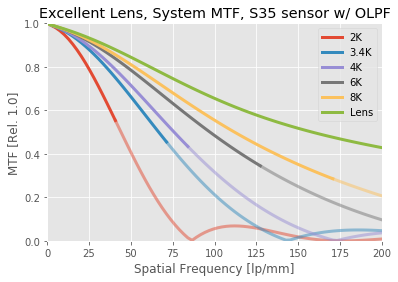

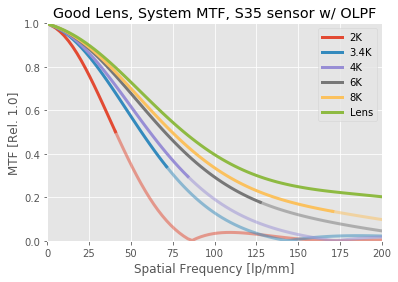

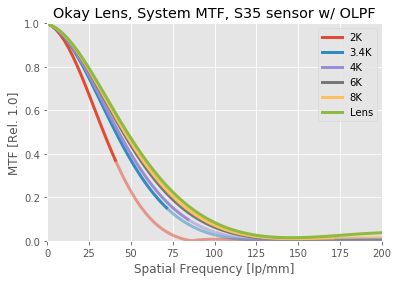

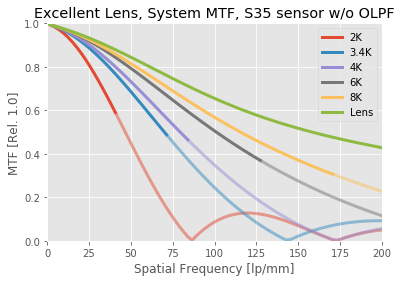

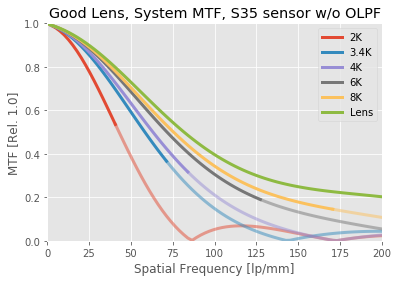

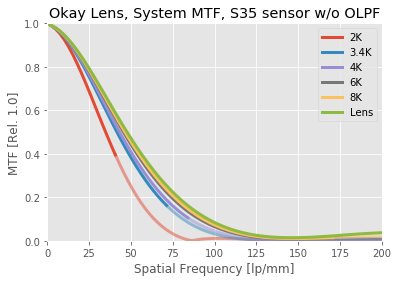

In [17]:
# plot the system MTF vs frequency curves for different pixel sizes
plt.style.use('ggplot')
def plot_sys_mtf_freq(data_array, has_olpf):
    if has_olpf:
        olpf_str = 'w/ OLPF'
        olpf_addon = 'olpf'
    else:
        olpf_str = 'w/o OLPF'
        olpf_addon = ''
    for (idx, lens_name), mtf in zip(enumerate(lens_names), ref_mtfs):
        fig, ax = plt.subplots()
        for (idx2, name), nyquist in zip(enumerate(res_names), nyquists):
            x, y = data_array[idx,0,idx2], data_array[idx,1,idx2]
            idx3 = np.searchsorted(x, nyquist)
            ln, = ax.plot(x[:idx3], y[:idx3], lw=3, label=name) # 
            ax.plot(x[idx3-1:], y[idx3-1:], lw=3, c=ln.get_color(), alpha=0.5)
        ax.plot(*mtf.tan, lw=3, label='Lens')
        ax.set(xlim=(0,200), xlabel='Spatial Frequency [lp/mm]',
               ylim=(0,1), ylabel='MTF [Rel. 1.0]',
               title=f'{lens_name} Lens, System MTF, S35 sensor {olpf_str}')
        plt.legend()
        plt.savefig(f'Video_outputs/{lens_name}_sys_mtf_{olpf_addon}.png', **plt_args)

plot_sys_mtf_freq(data_olpf, True)
plot_sys_mtf_freq(data_olpfless, False)

In [18]:
# track the system performance at different frequencies, equivalent to "zoom" in photoshop or any other editor
zoom_names = ['25%', '50%', '100%']
thresholds_excellent = [0.80, 0.60, 0.35]
thresholds_good =      [0.65, 0.40, 0.15]
threshold_acceptable = [0.50, 0.20, 0.05]

threshes = [thresholds_excellent, thresholds_good, threshold_acceptable]

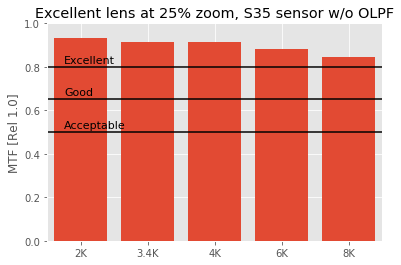

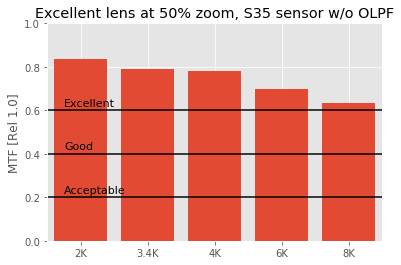

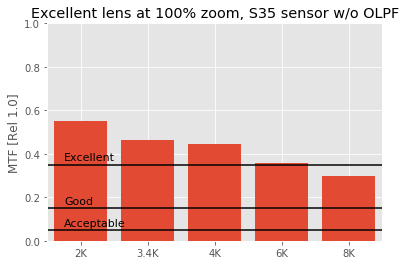

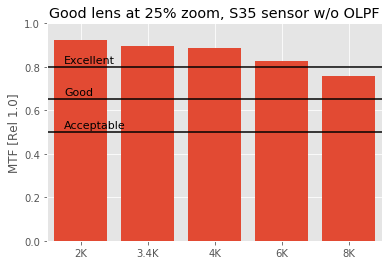

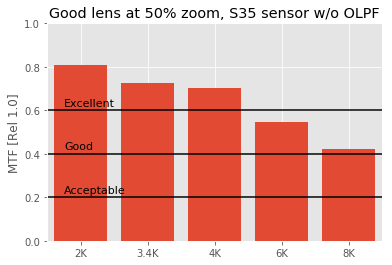

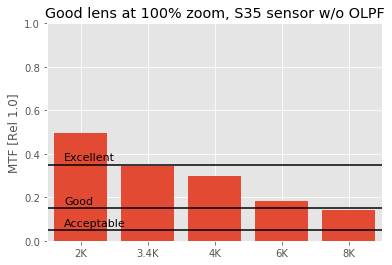

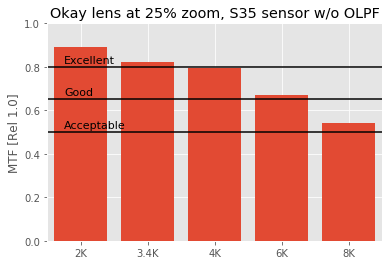

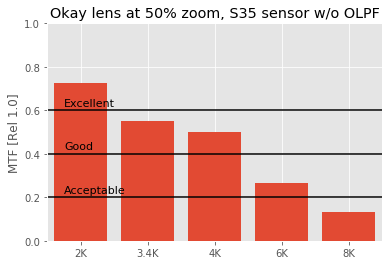

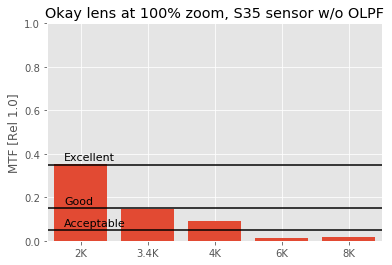

In [19]:
plt.style.use('ggplot')
def plot_sys_mtf_zoom(raw_data_array, has_olpf):
    if has_olpf:
        olpf_str = 'w/ OLPF'
        olpf_addon = 'olpf'
    else:
        olpf_str = 'w/o OLPF'
        olpf_addon = ''
    yvals = []
    for (idx, lens_name) in enumerate(lens_names):
        _1 = []
        _2 = []
        _4 = []
        for idx2, name in enumerate(res_names):
            unit = raw_data_array[idx,0,idx2]
            data = raw_data_array[idx,1,idx2]
            
            idx_n = np.searchsorted(unit, nyquists[idx2])
            idx_n2 = np.searchsorted(unit, half_nyquists[idx2])
            idx_n4 = np.searchsorted(unit, quarter_nyquists[idx2])
            
            _1.append(data[idx_n])
            _2.append(data[idx_n2])
            _4.append(data[idx_n4])
        yvals.append([_4, _2, _1])
    
    # yvals has shape (lens,zoom,sensor)
    data = np.asarray(yvals)
    for idx, lens_name in enumerate(lens_names):
        for (idx2, zoom), te, tg, ta in zip(enumerate(zoom_names), thresholds_excellent, thresholds_good, threshold_acceptable):
            fig, ax = plt.subplots()
            sys_mtfs = data[idx,idx2,:]
            xpos = list(range(len(sys_mtfs)))
            xmax = xpos[-1]
            ax.bar(xpos, sys_mtfs)
            ax.hlines(y=te, xmin=-1, xmax=xmax+1)
            ax.hlines(y=tg, xmin=-1, xmax=xmax+1)
            ax.hlines(y=ta, xmin=-1, xmax=xmax+1)
            ax.text(-0.25, te+0.01, 'Excellent', va='bottom', fontsize=11)
            ax.text(-0.25, tg+0.01, 'Good', va='bottom', fontsize=11)
            ax.text(-0.25, ta+0.01, 'Acceptable', va='bottom', fontsize=11)
            ax.set(xlim=(-0.5,xmax+0.5), ylim=(0,1), 
               xticks=xpos, xticklabels=res_names,
               ylabel='MTF [Rel 1.0]', title=f'{lens_name} lens at {zoom} zoom, S35 sensor {olpf_str}')
            plt.savefig(f'Video_outputs/{lens_name}_{zoom}_mtf_{olpf_addon}.png', **plt_args)

plot_sys_mtf_zoom(data_olpfless, False)

In [20]:
star = SiemensStar(80, False, 'white', 1, 8000)
sampled_stars = []
for pixel in pixel_sizes:
    d = Detector(pixel)
    sampled_stars.append(d.sample_image(star))

img_ex = []
img_good = []
img_okay = []
for img, res in zip(sampled_stars, res_names):
    ex = img.convpsf(psf_excellent)
    good = img.convpsf(psf_good)
    okay = img.convpsf(psf_okay)
    ex.save(f'Video_outputs/Excellent lens {res}.png')
    good.save(f'Video_outputs/Good lens {res}.png')
    okay.save(f'Video_outputs/Okay lens {res}.png')
    
    img_ex.append(ex)
    img_good.append(good)
    img_okay.append(okay)

In [21]:
from PIL import Image
i_ok = Image.open('Video_outputs/Okay lens 8K.png')
i_ex = Image.open('Video_outputs/Excellent lens 8K.png')

final_width = 300
shift = final_width // 2
w, h = i_ex.size
w /= 2
h /= 2
i_ok.crop((w-shift, h-shift, w+shift, h+shift)).save('Video_outputs/Okay lens 8K_cntr.png')
i_ex.crop((w-shift, h-shift, w+shift, h+shift)).save('Video_outputs/Excellent lens 8K_cntr.png')